<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B30_3%5D_Denoising_Autoencoder_Kuzushiji_MNIST_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Denoising AutoEncoder

Trains a denoising autoencoder on Kuzushiji-MNIST dataset.

Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.

<img src="https://miro.medium.com/max/1838/1*nmnm2rRJjaBD1TCUgL4dmA.png" height=200 />

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from PIL import Image


import tensorflow_datasets as tfds

# Load Kuzushiji-MNIST Dataset

In [38]:
dataset = tfds.load(name="mnist")

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

W0809 03:17:58.498780 140380920309632 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


In [0]:
x_train = []
y_train = []
x_test = []
y_test = []

In [0]:
for example in tfds.as_numpy(dataset['train']):
  new_img = example['image']
  x_train.append(new_img)
  y_train.append(example['label'])
  
for example in tfds.as_numpy(dataset['test']):
  new_img = example['image']
  x_test.append(new_img)
  y_test.append(example['label'])

In [41]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print('X_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('X_test.shape  =',x_test.shape)
print('y_test.shape  =',y_test.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
image_size = x_train.shape[1]

X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000,)
X_test.shape  = (10000, 28, 28, 1)
y_test.shape  = (10000,)


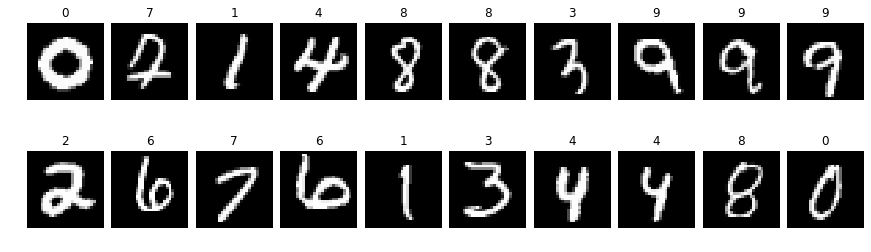

In [42]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(x_train[i+j*10,:,:,0], cmap='gray')
        ax[j,i].set_title(y_train[i+j*10])
        ax[j,i].axis('off')
plt.show()

In [0]:
np.random.seed(1337)

# Artifically Corrupt Images
* generate corrupted MNIST images by adding noise with normal dist
* centered at 0.5 and std=0.5
* normalize by clip pixel values >1.0 to 1.0 and <0.0 to 0.0

In [0]:

noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


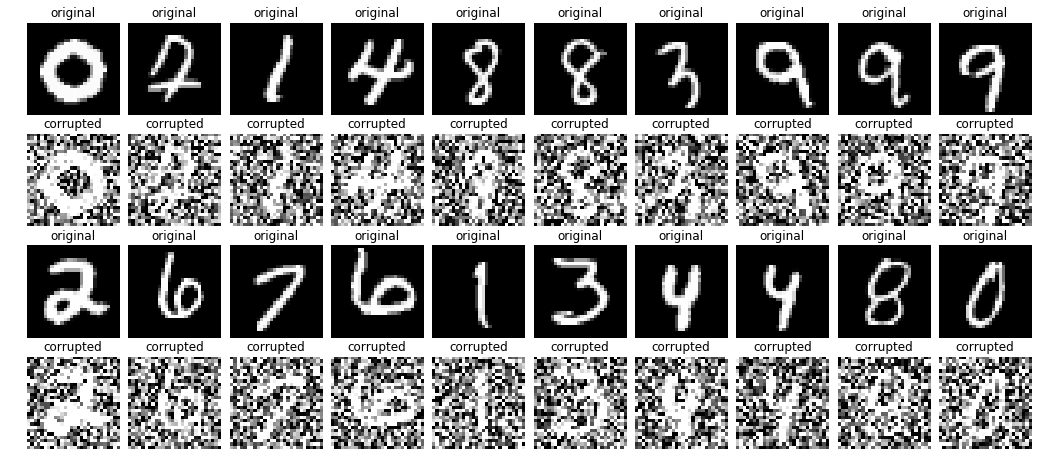

In [45]:
fig, ax = plt.subplots(4,10,figsize=(18,8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
k=1
for j in range(0,2):
    for i in range(0, 10):
        ax[j+k-1,i].imshow(x_train[i+j*10,:,:,0], cmap='gray')
        ax[j+k-1,i].set_title('original')
        ax[j+k-1,i].axis('off')
        ax[j+k,i].imshow(x_train_noisy[i+j*10,:,:,0], cmap='gray')
        ax[j+k,i].set_title('corrupted')
        ax[j+k,i].axis('off')
    k+=1
        
plt.show()

In [0]:
# network parameters
input_shape = (image_size, image_size, 1)
latent_dim = 256


# Encoder Model
 build the encoder model

In [65]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
x = Conv2D(32, 3,strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, 3,strides=2, activation='relu', padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               803072    
Total params: 821,888
Trainable params: 821,888
Non-trainable params: 0
_________________________________________________________________


# Decoder Model
 build the decoder model

In [66]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 3136)              805952    
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 861,633
Trainable params: 861,633
Non-trainable params: 0
_____________________________________________________

# Autoencoder = Encoder + Decoder
instantiate autoencoder model

In [67]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 256)               821888    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         861633    
Total params: 1,683,521
Trainable params: 1,683,521
Non-trainable params: 0
_________________________________________________________________


# Train the AutoEncoder

Compile using MSE loss and Adam Optimizer

In [68]:
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(x_train_noisy, x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=256)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0706 - val_loss: 0.0417
Epoch 2/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0268 - val_loss: 0.0184
Epoch 3/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0165 - val_loss: 0.0148
Epoch 4/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0140 - val_loss: 0.0135
Epoch 5/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0129 - val_loss: 0.0127
Epoch 6/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0123 - val_loss: 0.0124
Epoch 7/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0117 - val_loss: 0.0122
Epoch 8/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0113 - val_loss: 0.0120
Epoch 9/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0110 - val_

# Denoise Input Image

predict the autoencoder output from corrupted test images

In [0]:
x_decoded = autoencoder.predict(x_test_noisy)

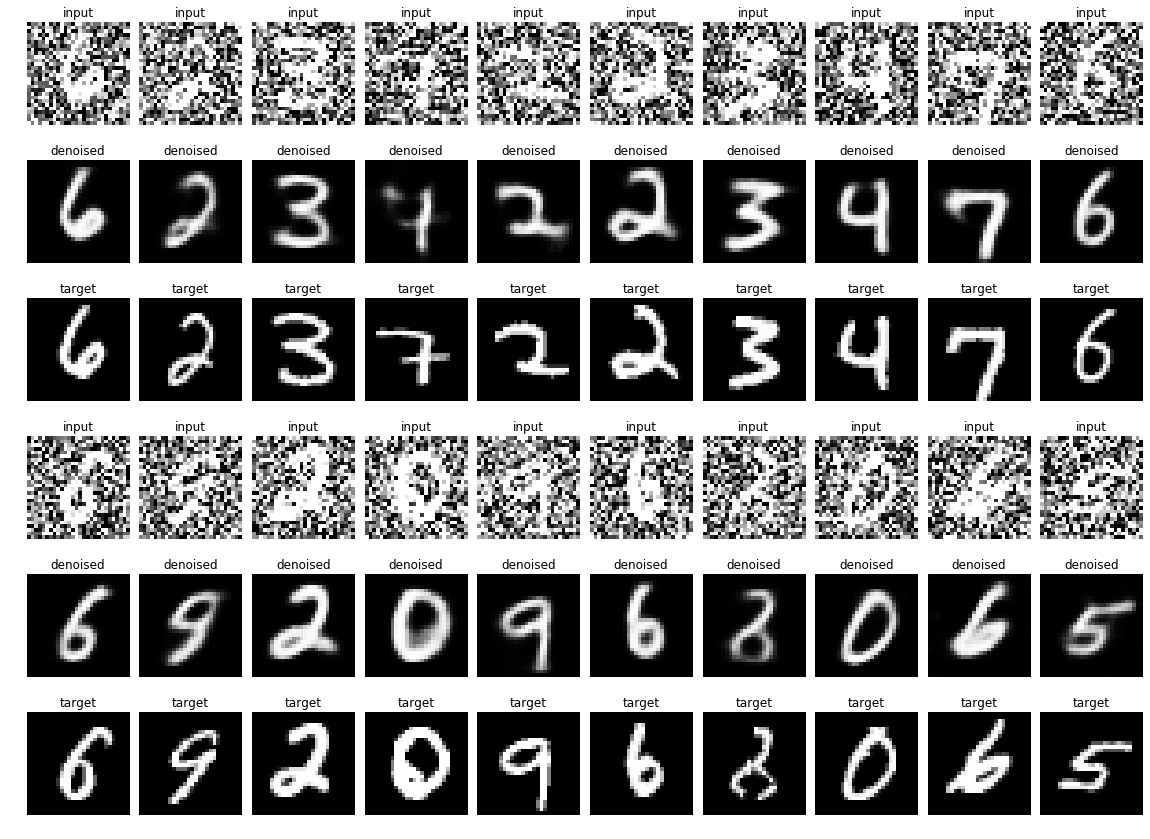

In [52]:
fig, ax = plt.subplots(6,10,figsize=(20,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
k=2
for j in range(0,2):
    for i in range(0, 10):
        ax[j+k-2,i].imshow(x_test_noisy[i+j*10,:,:,0], cmap='gray')
        ax[j+k-2,i].set_title('input')
        ax[j+k-2,i].axis('off')
        ax[j+k-1,i].imshow(x_decoded[i+j*10,:,:,0], cmap='gray')
        ax[j+k-1,i].set_title('denoised')
        ax[j+k-1,i].axis('off')
        ax[j+k,i].imshow(x_test[i+j*10,:,:,0], cmap='gray')
        ax[j+k,i].set_title('target')
        ax[j+k,i].axis('off')
    k+=2
        
plt.show()

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>